In [51]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import NamedTuple
import math
from enum import Enum, auto
import re
from matplotlib.ticker import PercentFormatter

In [52]:
class Actor(Enum):
    GAITNET = "gaitnet"
    CONTACTNET = "contactnet"

In [53]:
file_name_regex = re.compile(r'([a-zA-Z]+)_eval_d(\d+(?:\.\d+)?)_v(\d+(?:\.\d+)?)(?:_commit(\w+))\.csv')
"""match groups:
 - 1: network (gaitnet or contactnet)
 - 2: terrain difficulty (float)
 - 3: command velocity (float)
 - 4: commit (str)
"""

class DataPoint(NamedTuple):
    network: Actor
    commit: str 
    terrain_difficulty: float
    command_velocity: float
    distances: np.ndarray
    success: np.ndarray

    @staticmethod
    def from_csv(file_path: Path) -> "DataPoint":
        df = pd.read_csv(file_path)

        match = file_name_regex.match(file_path.name)
        if match is None:
            raise ValueError(f"Filename {file_path.name} does not match expected pattern")

        if len(match.groups()) == 3:
            network_str, terrain_difficulty, command_velocity = match.groups()
            commit = "unknown"
        else:
            network_str, terrain_difficulty, command_velocity, commit = match.groups()

        network = Actor(network_str)
        terrain_difficulty = float(terrain_difficulty)
        command_velocity = float(command_velocity)

        distances = df['distance'].to_numpy()
        success = df['truncated'].to_numpy().astype(bool)
        
        return DataPoint(
            network=network,
            commit=commit,
            terrain_difficulty=terrain_difficulty,
            command_velocity=command_velocity,
            distances=distances,
            success=success
        )

In [ ]:
data_folder = Path.cwd()  / "data" / "gaitnet_20251029_212018-6f5e92ae-survival-curr"
data_files = list(data_folder.glob("*.csv"))
all_data_points = [DataPoint.from_csv(fp) for fp in data_files]
all_data_points

[DataPoint(network=<Actor.GAITNET: 'gaitnet'>, commit='6f5e92ae', terrain_difficulty=0.2, command_velocity=0.2, distances=array([1.1554891 , 0.68483466, 1.7274963 , 2.6204035 , 0.92202324,
        2.9783328 , 2.8392172 , 2.7695043 , 1.2137258 , 2.6455772 ,
        0.27065986, 0.81528705, 2.7917652 , 2.838253  , 2.2938967 ,
        1.3617158 , 1.9263977 , 2.8282335 , 2.5432565 , 0.99687594,
        0.9481507 , 2.7811913 , 0.5383649 , 0.12079847, 2.8745189 ,
        0.58524996, 1.5971893 , 0.24549854, 0.7916126 , 1.3660696 ,
        2.598098  , 0.9823035 , 0.8602969 , 2.6763058 , 2.6724737 ,
        2.6711571 , 0.89975303, 2.2211075 , 2.543137  , 2.6683478 ,
        2.6312735 , 2.9963086 , 2.8043253 , 2.8696895 , 2.7895465 ,
        2.8008244 , 0.9150193 , 2.6666229 , 2.4281392 , 0.18120451]), success=array([False, False, False,  True, False,  True,  True,  True, False,
         True, False, False,  True,  True, False, False, False,  True,
         True, False, False,  True, False, False

In [55]:
# get a map from (network, commit) to list of DataPoints
data_map: dict[tuple[Actor, str], list[DataPoint]] = {}
for dp in all_data_points:
    key = (dp.network, dp.commit)
    if key not in data_map:
        data_map[key] = []
    data_map[key].append(dp)

In [56]:
def auc(data: list[DataPoint]) -> float:
    """Compute the area under the curve for the given data points."""
    auc = 0.0
    for datum in data:
        auc += float(np.mean(datum.success))
    return auc

def mean_success(data: list[DataPoint]) -> float:
    return auc(data)/len(data)


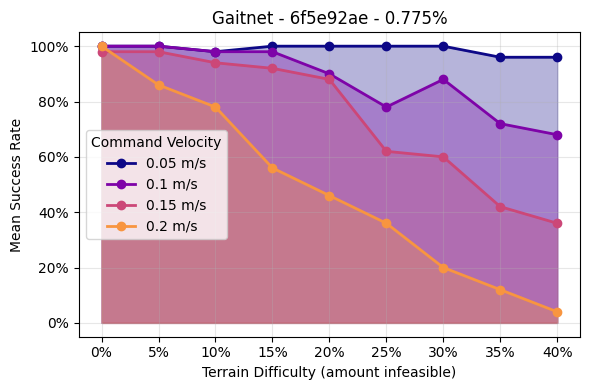

In [57]:
# plot 2d line plots of terrain difficulty (x) and mean success rate (y)
# one plot for each network, with a line for each command velocity

# Use a colormap for velocity progression
cmap = plt.cm.plasma
colors = cmap(np.linspace(0, 1, 5))  # 4 velocities

for (network, commit), network_data in data_map.items():
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Get unique terrain difficulties and command velocities
    unique_difficulties = sorted(set(dp.terrain_difficulty for dp in network_data))
    unique_velocities = sorted(set(dp.command_velocity for dp in network_data))
    
    # Plot a line for each command velocity with color progression
    for i, velocity in enumerate(unique_velocities):
        velocity_data = [dp for dp in network_data if dp.command_velocity == velocity]
        velocity_data = sorted(velocity_data, key=lambda dp: dp.terrain_difficulty)
        
        difficulties = [dp.terrain_difficulty for dp in velocity_data]
        success_rates = [np.mean(dp.success) for dp in velocity_data]
        
        ax.plot(difficulties, success_rates, marker='o', label=f'{velocity} m/s', 
                linewidth=2, markersize=6, color=colors[i])
        ax.fill_between(difficulties, success_rates, alpha=0.3, color=colors[i])
    
    ax.set_title(f'{network.value.capitalize()} - {commit} - {mean_success(network_data):.3f}%')
    ax.set_xlabel('Terrain Difficulty (amount infeasible)')
    ax.set_ylabel('Mean Success Rate')
    ax.set_ylim(-0.05, 1.05)
    
    # Format axes as percentages (assumes values in [0, 1])
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    
    # Set x-axis ticks to only show where data points exist
    ax.set_xticks(unique_difficulties)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3)
    
    # Add legend
    ax.legend(title='Command Velocity', loc='best')

    plt.tight_layout(w_pad=5.0)  # Increase horizontal padding between subplots
    plt.savefig(f'{network.value.capitalize()} - {commit}', dpi=300, bbox_inches='tight', pad_inches=0.3)